In [1]:
from trajectree.fock_optics.utils import create_vacuum_state
from trajectree.fock_optics.light_sources import light_source
from trajectree.fock_optics.devices import ry, rx, rz
from trajectree.fock_optics.measurement import create_threshold_POVM_OP_Dense, rotate_and_measure, create_PNR_POVM_OP_Dense
from trajectree.fock_optics.outputs import print_quantum_state, read_quantum_state
from trajectree.fock_optics.noise_models import single_mode_bosonic_noise_channels, depolarizing_operators, two_qubit_depolarizing_channel

from trajectree.trajectory import trajectory_evaluator, quantum_channel

import numpy as np
from scipy import sparse as sp
import qutip as qt
from numpy import sqrt
import time
import copy
from quimb.tensor.tensor_arbgeom import tensor_network_apply_op_vec #type: ignore
from quimb.tensor import MatrixProductOperator as mpo #type: ignore

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

/home/asingal/home/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/asingal/home/.venv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


This function simply creates a perfect bell state on photons. 

In [2]:
def create_perfect_bell_state(N=3, error_tolerance = 1e-10):
    # Defining the control and target inputs here
    a_dag = qt.create(N).full()
    I = qt.identity(N).full()

    a_H = np.kron(a_dag, I)
    a_V = np.kron(I, a_dag)

    # Testing the case with only one MPS for both control and target
    vacuum = create_vacuum_state(num_modes=4, N=N)
    pure_EPPS_operator = 1/sqrt(2) * (np.kron(a_H, a_H) + np.kron(a_V, a_V))
    pure_EPPS_operator_MPO = mpo.from_dense(pure_EPPS_operator, dims = N, sites = (0,1,2,3), L=4, tags="ideal_state")    
    psi = tensor_network_apply_op_vec(pure_EPPS_operator_MPO, vacuum, compress=True, contract = True, cutoff = error_tolerance)
    return psi

Now, we define some functions for running the CHSH experiment and calculating the CHSH value. 

In [3]:
N = 4

def create_POVMs(efficiency, N, PNR = False):
    if not PNR:
        POVM_0 = create_threshold_POVM_OP_Dense(efficiency, 0, N)
        POVM_1 = create_threshold_POVM_OP_Dense(efficiency, 1, N)
    else:
        POVM_0 = create_PNR_POVM_OP_Dense(efficiency, 0, N, debug = False)
        POVM_1 = create_PNR_POVM_OP_Dense(efficiency, 1, N, debug = False)

    POVM_H = sp.csr_matrix( np.kron(POVM_1, POVM_0) ) # H detector clicks, V does not
    POVM_V = sp.csr_matrix( np.kron(POVM_0, POVM_1) ) # V detector clicks, H does not
    POVM_N = sp.csr_matrix( np.kron(POVM_0, POVM_0) ) # No detector clicks (Not used yet)
    POVM_B = sp.csr_matrix( np.kron(POVM_1, POVM_1) ) # Both detectors click (Not used yet)    

    return POVM_H, POVM_V, POVM_N, POVM_B

def calc_CHSH_measurements(POVM_H, POVM_V, POVM_N, POVM_B, dm):
    E = []
    for POVM_a in [POVM_H, POVM_V, POVM_N, POVM_B]:
        for POVM_b in [POVM_H, POVM_V, POVM_N, POVM_B]:
            E.append( (sp.kron(POVM_a, POVM_b) @ dm).trace().real )
    return E


def calc_CHSH_value(dm, efficiency, N, PNR = False):

    # First, we define some constants that we will be using for the experiment. 
    I = np.eye(N**2)
    ry_pi_4 = ry(np.pi/4, N, return_unitary=True)
    ry_pi_2 = ry(np.pi/2, N, return_unitary=True)

    op_00 = sp.csr_matrix( np.kron(I, ry_pi_4) @ np.kron(ry_pi_2, I) )
    op_01 = sp.csr_matrix( np.kron(I, ry_pi_4) @ np.kron(ry_pi_2, ry_pi_2) )
    op_10 = sp.csr_matrix( np.kron(I, ry_pi_4) @ np.kron(I, I) )
    op_11 = sp.csr_matrix( np.kron(I, ry_pi_4) @ np.kron(I, ry_pi_2) )

    measurements = [ 1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1]
                 # [HH, HV, HN, HB, VH, VV, VN, VB, NH, NV, NN, NB, BH, BV, BN, BB]
    mask = [measurements, measurements, measurements, [-x for x in measurements]] 
    
    POVM_H, POVM_V, POVM_N, POVM_B = create_POVMs(efficiency, N, PNR)

    dm_00 = op_00 @ dm @ op_00.conj().T
    E_00 = calc_CHSH_measurements(POVM_H, POVM_V, POVM_N, POVM_B, dm_00)
        
    dm_01 = op_01 @ dm @ op_01.conj().T
    E_01 = calc_CHSH_measurements(POVM_H, POVM_V, POVM_N, POVM_B, dm_01)

    dm_10 = op_10 @ dm @ op_10.conj().T
    E_10 = calc_CHSH_measurements(POVM_H, POVM_V, POVM_N, POVM_B, dm_10)

    dm_11 = op_11 @ dm @ op_11.conj().T
    E_11 = calc_CHSH_measurements(POVM_H, POVM_V, POVM_N, POVM_B, dm_11)

    return np.sum(np.multiply([E_00, E_01, E_10, E_11], mask)).real

    ############ Previous method of calculating CHSH value
    # CHSH_value = (E_00_00 - E_00_01 - E_00_10 + E_00_11) + (E_01_00 - E_01_01 - E_01_10 + E_01_11) + (E_10_00 - E_10_01 - E_10_10 + E_10_11) - (E_11_00 - E_11_01 - E_11_10 + E_11_11)
    # CHSH_values.append(CHSH_value)



    # expectation_matrix = [np.array([E_00_00, E_00_01, E_00_10, E_00_11])/sum([E_00_00, E_00_01, E_00_10, E_00_11]),
    #                       np.array([E_01_00, E_01_01, E_01_10, E_01_11])/sum([E_01_00, E_01_01, E_01_10, E_01_11]),
    #                       np.array([E_10_00, E_10_01, E_10_10, E_10_11])/sum([E_10_00, E_10_01, E_10_10, E_10_11]),
    #                       np.array([E_11_00, E_11_01, E_11_10, E_11_11])/sum([E_11_00, E_11_01, E_11_10, E_11_11])]
    
    # print(np.sum(np.multiply(expectation_matrix, mask), axis = 1))


The first experiment we do is to vary the depolarization rate and calculate the CHSH value. We first do it for the case of a perfect bell pair. We can use both the single qubit or 2 qubit depolarization channels, which produce different CHSH curves. 

CHSH minima at depolarization rate: 0.7368421052631579
Max. CHSH value: 2.8284271247461916


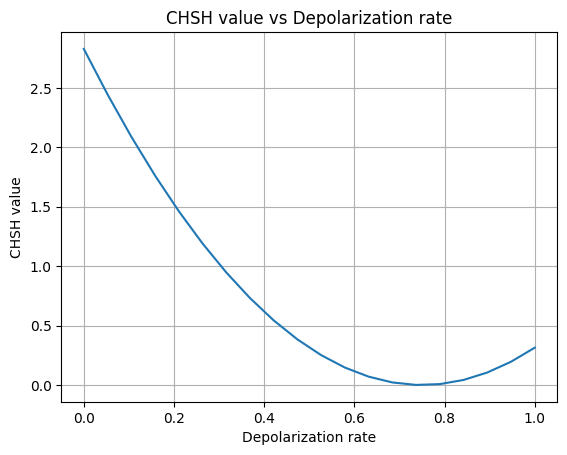

In [4]:
mean_photon_num = 0.25
efficiency = 1
error_tolerance = 1e-10
loss_rate = 0
depolarization_rate_list = np.linspace(0, 1, 20)

# vacuum = create_vacuum_state(num_modes=8, N=N)
# _, psi = light_source(vacuum, N, mean_photon_num, 8, error_tolerance, compress=True, contract=True)
psi = sp.csr_array(create_perfect_bell_state(N, error_tolerance).to_dense())

dm = psi @ psi.conj().T

CHSH_values = []
for depolarization_rate in depolarization_rate_list:

    direct_dm_depol = 0
    
    ############ Using two qubit depolarizing channel
    # depolarizing_kraus_ops = two_qubit_depolarizing_channel(depolarizing_probability = depolarization_rate, N = N)
    # for i in depolarizing_kraus_ops:
    #     direct_dm_depol += i @ dm @ i.conj().T

    ############ Using single qubit depolarizing channel on each qubit
    depolarizing_kraus_ops = depolarizing_operators(depolarization_rate, N)
    for i in depolarizing_kraus_ops:
        for j in depolarizing_kraus_ops:
            depol_op = sp.kron(i, j)
            direct_dm_depol += depol_op @ dm @ depol_op.conj().T

    direct_dm = 0
    loss_kraus_ops = single_mode_bosonic_noise_channels(loss_rate, N)
    for i in loss_kraus_ops:
        for j in loss_kraus_ops:
            for k in loss_kraus_ops:
                for l in loss_kraus_ops:
                    kraus_op = sp.kron(i, sp.kron(j, sp.kron(k,l)))
                    direct_dm += kraus_op @ direct_dm_depol @ kraus_op.conj().T

    CHSH_values.append(calc_CHSH_value(direct_dm, efficiency, N))

index = np.where(CHSH_values == min(CHSH_values))[0][0]

print("CHSH minima at depolarization rate:", depolarization_rate_list[index])
print("Max. CHSH value:", max(CHSH_values))
plt.plot(depolarization_rate_list, CHSH_values)
plt.title("CHSH value vs Depolarization rate")
plt.xlabel("Depolarization rate")
plt.ylabel("CHSH value")
plt.grid()

Now, we use a realistic source for the same exeriment. Note again that both the depolarization channels can be used. 

CHSH minima at depolarization rate: 1.0
Max. CHSH value: 2.8284271247461916


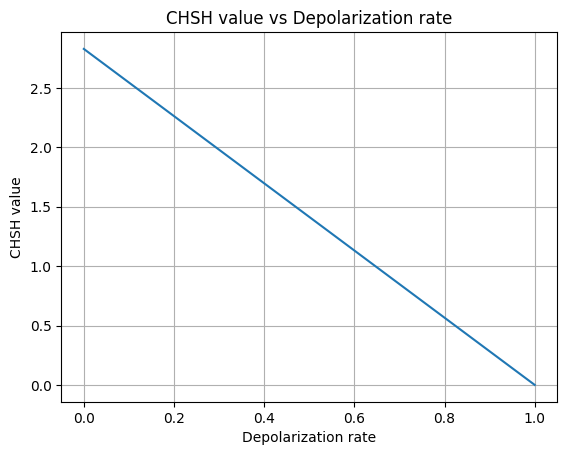

In [5]:
mean_photon_num = 0.5
efficiency = 1
error_tolerance = 1e-10
loss_rate = 0
depolarization_rate_list = np.linspace(0, 1, 20)

vacuum = create_vacuum_state(num_modes=8, N=N)
# _, psi = light_source(vacuum, N, mean_photon_num, 8, error_tolerance, compress=True, contract=True)
psi = sp.csr_array(create_perfect_bell_state(N, error_tolerance).to_dense())

dm = psi @ psi.conj().T

CHSH_values = []
for depolarization_rate in depolarization_rate_list:

    direct_dm_depol = 0
    
    ############ Using two qubit depolarizing channel
    depolarizing_kraus_ops = two_qubit_depolarizing_channel(depolarizing_probability = depolarization_rate, N = N)
    for i in depolarizing_kraus_ops:
        direct_dm_depol += i @ dm @ i.conj().T

    ############ Using single qubit depolarizing channel on each qubit
    # depolarizing_kraus_ops = depolarizing_operators(depolarization_rate, N)
    # for i in depolarizing_kraus_ops:
    #     for j in depolarizing_kraus_ops:
    #         depol_op = sp.kron(i, j)
    #         direct_dm_depol += depol_op @ dm @ depol_op.conj().T

    direct_dm = 0
    loss_kraus_ops = single_mode_bosonic_noise_channels(loss_rate, N)
    for i in loss_kraus_ops:
        for j in loss_kraus_ops:
            for k in loss_kraus_ops:
                for l in loss_kraus_ops:
                    kraus_op = sp.kron(i, sp.kron(j, sp.kron(k,l)))
                    direct_dm += kraus_op @ direct_dm_depol @ kraus_op.conj().T

    CHSH_values.append(calc_CHSH_value(direct_dm, efficiency, N))

index = np.where(CHSH_values == min(CHSH_values))[0][0]

print("CHSH minima at depolarization rate:", depolarization_rate_list[index])
print("Max. CHSH value:", max(CHSH_values))
plt.plot(depolarization_rate_list, CHSH_values)
plt.title("CHSH value vs Depolarization rate")
plt.xlabel("Depolarization rate")
plt.ylabel("CHSH value")
plt.grid()

Now, we do the same experiment while varying the mean photon number of the source. We are not considering any depolarization in this experiment. 

CHSH minima at MPN: 0.5
Max. CHSH value: 1.9929939573539244


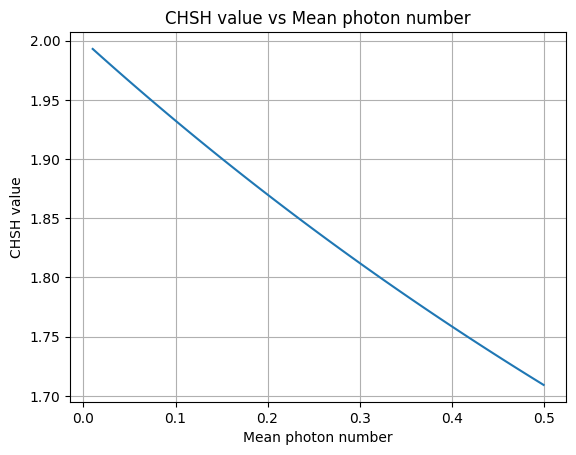

In [6]:
efficiency = 1
error_tolerance = 1e-10
loss_rate = 0.9
mpn_list = np.linspace(0.01, 0.5, 100)

CHSH_values = []
for mean_photon_num in mpn_list:

    vacuum = create_vacuum_state(num_modes=8, N=N)
    _, psi = light_source(vacuum, N, mean_photon_num, 8, error_tolerance, compress=True, contract=True)
    # psi = create_perfect_bell_state(N, error_tolerance)
    dm = psi @ psi.conj().T

    direct_dm = 0
    loss_kraus_ops = single_mode_bosonic_noise_channels(loss_rate, N)
    for i in loss_kraus_ops:
        for j in loss_kraus_ops:
            for k in loss_kraus_ops:
                for l in loss_kraus_ops:
                    kraus_op = sp.kron(i, sp.kron(j, sp.kron(k,l)))
                    direct_dm += kraus_op @ dm @ kraus_op.conj().T

    CHSH_values.append(calc_CHSH_value(direct_dm, efficiency, N))

index = np.where(CHSH_values == min(CHSH_values))[0][0]

print("CHSH minima at MPN:", mpn_list[index])
print("Max. CHSH value:", max(CHSH_values))

plt.plot(mpn_list, CHSH_values)
plt.title("CHSH value vs Mean photon number")
plt.xlabel("Mean photon number")
plt.ylabel("CHSH value")
plt.grid()

We see that the CHSH value seems to depend on the amount of loss in the system. So, we try to characterize that. 

[0.61584821 0.48329302 0.29763514 0.08858668 0.01       0.01
 0.01       0.01       0.01       0.01      ]


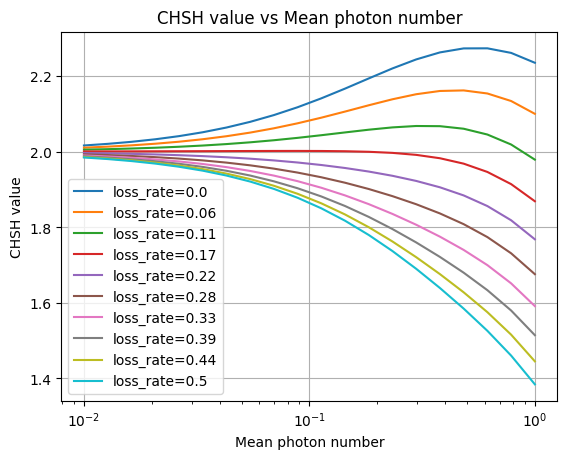

In [31]:
N = 4
efficiency = 1
error_tolerance = 1e-10
loss_rate_list = np.linspace(0, 0.5, 10)
mpn_list = np.logspace(-2, 0, 20)
indices = []

plt.figure()

for loss_rate in loss_rate_list:
    CHSH_values = []
    for mean_photon_num in mpn_list:

        vacuum = create_vacuum_state(num_modes=8, N=N)
        psi, TMSV_state = light_source(vacuum, N, mean_photon_num, 8, error_tolerance, compress=True, contract=True)
        # psi = create_perfect_bell_state(N, error_tolerance)
        dm = TMSV_state @ TMSV_state.conj().T

        direct_dm = 0
        loss_kraus_ops = single_mode_bosonic_noise_channels(loss_rate, N)
        for i in loss_kraus_ops:
            for j in loss_kraus_ops:
                for k in loss_kraus_ops:
                    for l in loss_kraus_ops:
                        kraus_op = sp.kron(i, sp.kron(j, sp.kron(k,l)))
                        direct_dm += kraus_op @ dm @ kraus_op.conj().T

        CHSH_values.append(calc_CHSH_value(direct_dm, efficiency, N))

    indices.append(np.where(CHSH_values == max(CHSH_values))[0][0])

    plt.plot(mpn_list, CHSH_values, label="loss_rate="+str(round(loss_rate,2)))

print(mpn_list[indices])
plt.title("CHSH value vs Mean photon number")
plt.xlabel("Mean photon number")
plt.ylabel("CHSH value")
plt.xscale('log')
plt.legend()
plt.grid()

This looks good! Particularly note the fact that the CHSH value is greater than 2 only when the loss rate is lower than 0.17. This means that a detection EFFICIENCY (=1-loss_rate) of about 83% is required for demonstrating quantum nature. 

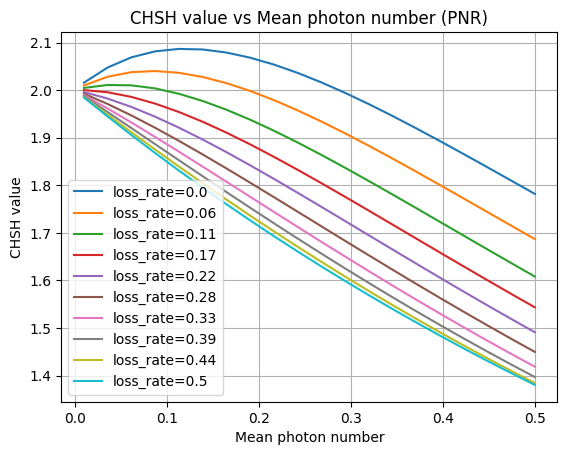

In [8]:
efficiency = 1
error_tolerance = 1e-10
loss_rate_list = np.linspace(0, 0.5, 10)
mpn_list = np.linspace(0.01, 0.5, 20)

plt.figure()

for loss_rate in loss_rate_list:
    CHSH_values = []
    for mean_photon_num in mpn_list:

        vacuum = create_vacuum_state(num_modes=8, N=N)
        psi, TMSV_state = light_source(vacuum, N, mean_photon_num, 8, error_tolerance, compress=True, contract=True)
        # psi = create_perfect_bell_state(N, error_tolerance)
        dm = TMSV_state @ TMSV_state.conj().T

        direct_dm = 0
        loss_kraus_ops = single_mode_bosonic_noise_channels(loss_rate, N)
        for i in loss_kraus_ops:
            for j in loss_kraus_ops:
                for k in loss_kraus_ops:
                    for l in loss_kraus_ops:
                        kraus_op = sp.kron(i, sp.kron(j, sp.kron(k,l)))
                        direct_dm += kraus_op @ dm @ kraus_op.conj().T

        CHSH_values.append(calc_CHSH_value(direct_dm, efficiency, N, PNR = True))

    index = np.where(CHSH_values == min(CHSH_values))[0][0]

    plt.plot(mpn_list, CHSH_values, label="loss_rate="+str(round(loss_rate,2)))

plt.title("CHSH value vs Mean photon number (PNR)")
plt.xlabel("Mean photon number")
plt.ylabel("CHSH value")
plt.legend()
plt.grid()

## Now, we perform the same simulations with Trajectree 
This can help us expand the simulations (in terms of number of modes) further for performing PCS later. 
 
We first define a helper function to run a trajectree experiment. 

In [9]:
def perform_simulation(N, num_simulations, quantum_channels, error_tolerance = 1e-10, track_dm = False):

    # num_modes = 8
    # vacuum = create_vacuum_state(num_modes=num_modes, N=N)
    # psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
    
    psi = create_perfect_bell_state(N, error_tolerance)

    t_eval = trajectory_evaluator(quantum_channels)

    probabilities = []
    dm = 0

    for i in range(num_simulations): 
        start = time.time()
        psi_iter = copy.deepcopy(t_eval.perform_simulation(psi, error_tolerance, normalize = True))
        probabilities.append(psi_iter.normalize())
        if track_dm:
            dm += psi_iter.to_dense() @ psi_iter.to_dense().conj().T
        time_taken = time.time() - start

    if track_dm: 
        dm = dm/num_simulations
        return probabilities, dm

    return probabilities

Defining some simulation parameters. 

In [10]:
# params
trunc = 1
N = trunc+1
error_tolerance = 1e-12

idler_angles = [0, np.pi/2]
signal_angles = [np.pi/4, 3*np.pi/4]
CHSH_values = []
num_simulations = 50
depolarization_probabilities = np.linspace(0, 1, 10, endpoint=True)

We now run the CHSH experiment using trajectree.

In [11]:
import itertools

psi = create_perfect_bell_state(N, error_tolerance = 1e-10)
site_tags = psi.site_tags

measurements = []
all_meas = [0,1,2,3]
for num in range(5):
    a = itertools.combinations(all_meas, num)
    for i in a:
        measurements.append({1:tuple(x for x in all_meas if x not in i), 0:i})

for depolarization_probability in depolarization_probabilities:
    quantum_channel_list = []
    depolarizing_kraus_ops = two_qubit_depolarizing_channel(depolarizing_probability = depolarization_probability, N = N)
    quantum_channel_list.append(quantum_channel(N = N, num_modes = 4, formalism = "kraus", kraus_ops_tuple = ((0,1,2,3), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.
    
    CHSH_value = 0

    for idler_angle in idler_angles: # [0]: 
        for signal_angle in signal_angles: # [np.pi/4]: 
            for meas in measurements: # [{1: (1, 2), 0: (0, 3)}]:

                # First, we calculate the factor to be multiplied to the probabilities based on the measurement outcomes
                factor = 1
                if (1 in meas[1] and 0 not in meas[1]):
                    factor *= -1
                if (3 in meas[1] and 2 not in meas[1]):
                    factor *= -1

                # Now, we perform the simulation. 
                PA_OPS = rotate_and_measure(None, N, psi.site_tags, psi.L, efficiency, error_tolerance, [idler_angle], [signal_angle], rotations = {"signal":(0,1), "idler":(2,3)}, measurements = meas, return_MPOs = True)
                PA_quantum_channels = [quantum_channel(N = N, num_modes = 4, formalism = "closed", unitary_MPOs = PA_MPO) for PA_MPO in PA_OPS]
                prob = perform_simulation(N, num_simulations, quantum_channel_list+PA_quantum_channels, track_dm = False)

                # print(np.round(np.mean(prob), 10), idler_angle, signal_angle, meas)
                
                if idler_angle == 0 and signal_angle == 3*np.pi/4:
                    CHSH_value += -factor * np.mean(prob) # Mean because the simulation function returns a list of probabilities for each Monte carlo iteration. 
                else:
                    CHSH_value += factor * np.mean(prob)
                

    CHSH_values.append(CHSH_value)



/home/asingal/home/quimb/quimb/tensor/tensor_1d.py:1867: RuntimeWarning: divide by zero encountered in divide
  self[insert].modify(data=self[insert].data / norm**0.5)
/home/asingal/home/quimb/quimb/tensor/tensor_1d.py:1867: RuntimeWarning: invalid value encountered in divide
  self[insert].modify(data=self[insert].data / norm**0.5)


/home/asingal/home/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/asingal/home/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[np.complex128(2.828427124746188+0j),
 np.complex128(2.489015869776644+0j),
 np.complex128(2.276883835420685+0j),
 np.complex128(1.8596908345206193+0j),
 np.complex128(1.5485638507985378+0j),
 np.complex128(1.3222896808188431+0j),
 np.complex128(0.9050966799187798+0j),
 np.complex128(0.7283199846221446+0j),
 np.complex128(0.1484924240491749+0j),
 np.complex128(-0.14849242404917523+0j)]

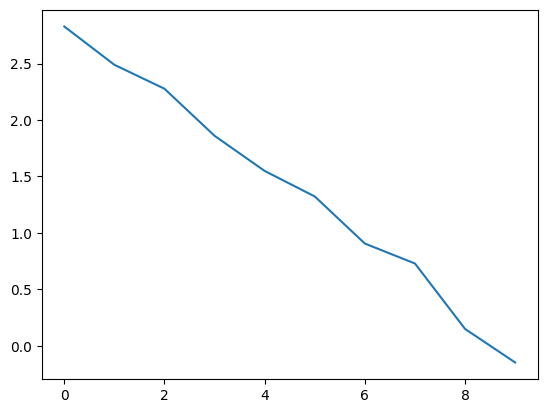

In [12]:
plt.plot(CHSH_values)
CHSH_values

We also run the same experiment on regular statevectors with the monte carlo simulations (Only for debugging, not integral for the actual simulations)


In [13]:
# op_00 = sp.csr_matrix( np.kron(I, ry_pi_4) @ np.kron(ry_pi_2, I) )
# op_01 = sp.csr_matrix( np.kron(I, ry_pi_4) @ np.kron(ry_pi_2, ry_pi_2) )
# op_10 = sp.csr_matrix( np.kron(I, ry_pi_4) @ np.kron(I, I) )
# op_11 = sp.csr_matrix( np.kron(I, ry_pi_4) @ np.kron(I, ry_pi_2) )
from scipy.linalg import sqrtm
ry_pi_4 = ry(np.pi/4, N, return_unitary=True)
I = np.eye(N**2)
depolarization_probability = 0.5

psi = create_perfect_bell_state(N, error_tolerance).to_dense()

depolarizing_kraus_ops = two_qubit_depolarizing_channel(depolarizing_probability = depolarization_probability, N = N)
num_iterations = 150

POVM_1_OP = sqrtm(create_threshold_POVM_OP_Dense(1, 1, N)).astype(np.complex128)
POVM_0_OP = sqrtm(create_threshold_POVM_OP_Dense(1, 0, N)).astype(np.complex128)
meas_op = np.kron(POVM_0_OP, np.kron(POVM_1_OP, np.kron(POVM_1_OP, POVM_0_OP)))

prob = 0

trajectory_probs = []
for op in depolarizing_kraus_ops:
    state = op @ psi
    trajectory_probs.append((state.conj().T @ state)[0][0].real)
# print(trajectory_probs)

for i in range(num_iterations):
    sample = np.random.choice(range(len(depolarizing_kraus_ops)), p = trajectory_probs)
    depolairized_state = depolarizing_kraus_ops[sample] @ psi
    depolairized_state *= (1/np.sqrt(trajectory_probs[sample]))
    # depolairized_state = depolarizing_kraus_ops[np.random.choice(len(depolarizing_kraus_ops))] @ psi
    rotated_state = np.kron(I, ry_pi_4) @ depolairized_state
    measured_state = meas_op @ rotated_state

    prob += (measured_state.conj().T @ measured_state)
print(prob/num_iterations)

# psi = create_perfect_bell_state(N, error_tolerance).to_dense()
# direct_dm_depol = 0
# dm = psi @ psi.conj().T
# for i in depolarizing_kraus_ops:
#     direct_dm_depol += i @ dm @ i.conj().T

# print(sp.csr_array(np.round(direct_dm_depol, 10)))

# dm_rotated = np.kron(I, ry_pi_4) @ direct_dm_depol @ np.kron(I, ry_pi_4).conj().T
# print(np.trace(meas_op @ dm_rotated))



prob = 0
for op in depolarizing_kraus_ops:
    depolairized_state = op @ psi
    rotated_state = np.kron(I, ry_pi_4) @ depolairized_state
    measured_state = meas_op @ rotated_state

    prob += (measured_state.conj().T @ measured_state)
    
print(prob)


[[0.16750421+0.j]]
[[0.16161165+0.j]]


## Here on, we are trying to recreate the density matrices using Trajectree. 
This is presently not working since Trajectree was modified such that the trajectories were divided by the sqrt of the probability of the trajectory to make the trajectory simulations work correctly. 

First, we find the density matrix explicitly using matrix multiplication. 

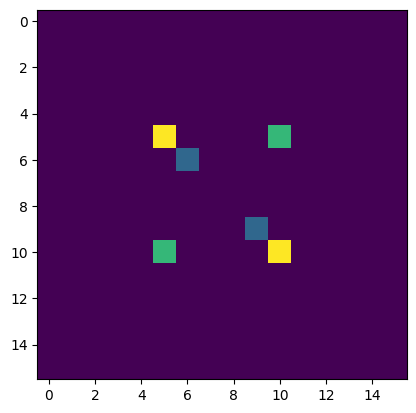

In [15]:
dm = psi @ psi.conj().T
# print(len(dm))
direct_dm = 0
for i in depolarizing_kraus_ops:
    direct_dm += i @ dm @ i.conj().T
plt.figure()
plt.imshow(np.round(np.real(direct_dm), 15))



Now, we use trajectree's in-built density matrix calculation method and compare the result with the explicit DM calculated the previous cell:

<Compressed Sparse Row sparse array of dtype 'complex128'
	with 0 stored elements and shape (16, 16)>


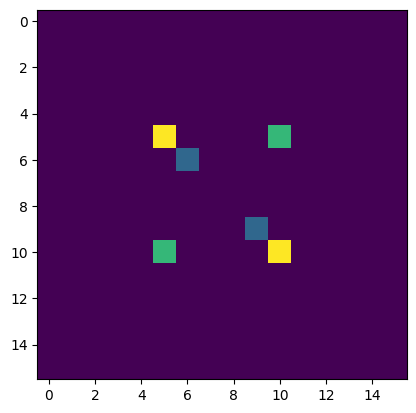

In [17]:
psi = create_perfect_bell_state(N, error_tolerance)

quantum_channel_list = []
quantum_channel_list.append(quantum_channel(N = N, num_modes = 8, formalism = "kraus", kraus_ops_tuple = ((0,1,2,3), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.

# Trajectree dm
t_eval = trajectory_evaluator(quantum_channel_list)
trajectree_dm = t_eval.calculate_density_matrix(psi, error_tolerance)

plt.figure()
# print(np.real(np.round(dm, 3)))
plt.imshow(np.real(np.round(trajectree_dm, 10)))


sp.csr_array(trajectree_dm - direct_dm)
print(sp.csr_array(np.round(trajectree_dm - direct_dm, 10)))


Now, we use trajectree to sample the trajectree using monte carlo simulations to recreate the density matrix and calculate the density matrices. 

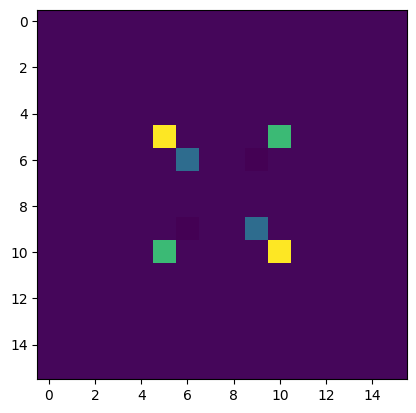

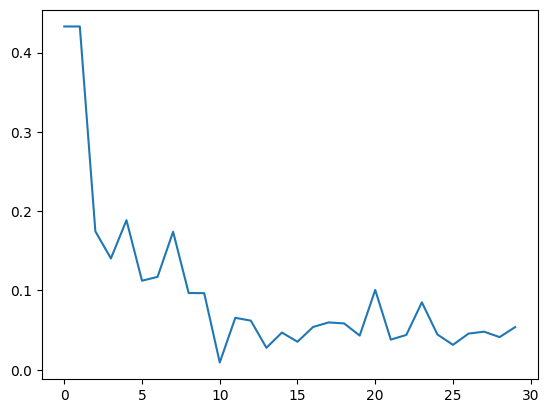

In [18]:
# Estimating the dm using trajectree
num_simulations = 300
 
fig, ax = plt.subplots()
ims = []
errors = []
estimated_dm = create_perfect_bell_state(N, error_tolerance).to_dense() @ create_perfect_bell_state(N, error_tolerance).to_dense().conj().T
for i in range(1, num_simulations, 10):
    errors.append(np.linalg.norm(estimated_dm - direct_dm))
    im = ax.imshow(np.real(estimated_dm), animated=True)
    ims.append([im])

    probs, estimated_dm = perform_simulation(N, i, quantum_channel_list, track_dm = True)

plt.figure()
plt.plot(errors)

ani = animation.ArtistAnimation(fig, ims)
display(HTML(ani.to_jshtml()))
ax.imshow(np.real(estimated_dm))

### We have verified the trajectree simulations!

Now, to validate the results from trajectree further, we will recreate the full CHSH experiment using full density matrices. 

In [19]:
efficiency = 1

num_simulations = 100
alice_angles = [np.pi/2, 0]
bob_angles = [np.pi/4, 3*np.pi/4]

depolarization_probabilities = np.linspace(0, 1, 10, endpoint=False) # np.linspace(0, 1, 2, endpoint=False) # np.linspace(0, 1, 30, endpoint=False)

Now, we know that optics should also produce the same result that the qubit version produces. So, we now first check if the density matrix from trajectree produces a similar result or not:

[np.float64(2.8284271247461907),
 np.float64(2.5512412665210635),
 np.float64(2.296682825293906),
 np.float64(1.7423111088436531),
 np.float64(1.7027131290972068),
 np.float64(1.1709688296449228),
 np.float64(0.939037805415735),
 np.float64(0.7240773439350247),
 np.float64(0.0565685424949236),
 np.float64(0.0)]

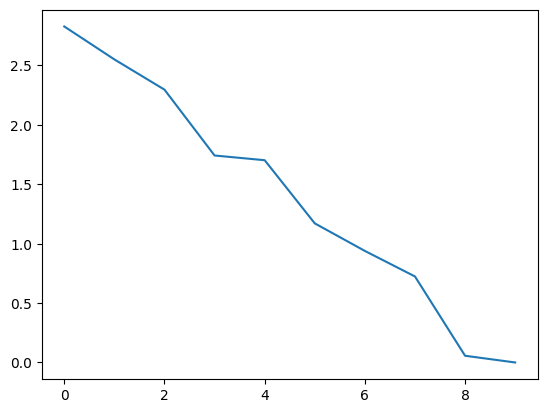

In [20]:
depolarization_rate_list = np.linspace(0, 1, 10)
CHSH_values = []

for depolarization_rate in depolarization_rate_list:
    quantum_channel_list = []
    depolarizing_kraus_ops = two_qubit_depolarizing_channel(depolarizing_probability = depolarization_rate, N = N)
    quantum_channel_list.append(quantum_channel(N = N, num_modes = 8, formalism = "kraus", kraus_ops_tuple = ((0,1,2,3), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.

    probs, direct_dm = perform_simulation(N, 500, quantum_channel_list, track_dm = True)

    CHSH_values.append(calc_CHSH_value(direct_dm, efficiency, N, PNR = False))

plt.plot(CHSH_values)
CHSH_values

We see that we get pretty much the same result with some shot noise, but otherwise acceptable results. 

## Everything after here is irrelevant. Its archived content. 

In [ ]:
psi = create_perfect_bell_state(N, error_tolerance)
print(psi.to_dense())

psi = psi * 0.5
print(psi.to_dense())

[[ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]
 [ 7.07106781e-01+0.j]
 [ 0.00000000e+00+0.j]
 [-5.47382213e-48+0.j]
 [ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]
 [ 7.07106781e-01+0.j]
 [ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]]
[[ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]
 [ 3.53553391e-01+0.j]
 [ 0.00000000e+00+0.j]
 [-2.73691106e-48+0.j]
 [ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]
 [ 3.53553391e-01+0.j]
 [ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j]]


In [ ]:
norm = np.linalg.norm(depolarizing_kraus_ops[0].toarray())
np.linalg.norm(depolarizing_kraus_ops[0].toarray()/norm)
# total = 0
# for i in depolarizing_kraus_ops:
#     total += i.conj().T @ i
# print(total)

np.float64(1.0)

In [ ]:
depolarizing_kraus_ops[1].toarray()

array([[0.1767767+0.j       , 0.       +0.j       , 0.       +0.j       ,
        0.       +0.j       , 0.       +0.j       , 0.       +0.j       ,
        0.       +0.j       , 0.       +0.j       , 0.       +0.j       ,
        0.       +0.j       , 0.       +0.j       , 0.       +0.j       ,
        0.       +0.j       , 0.       +0.j       , 0.       +0.j       ,
        0.       +0.j       ],
       [0.       +0.j       , 0.       +0.j       , 0.       -0.1767767j,
        0.       +0.j       , 0.       +0.j       , 0.       +0.j       ,
        0.       +0.j       , 0.       +0.j       , 0.       +0.j       ,
        0.       +0.j       , 0.       +0.j       , 0.       +0.j       ,
        0.       +0.j       , 0.       +0.j       , 0.       +0.j       ,
        0.       +0.j       ],
       [0.       +0.j       , 0.       -0.1767767j, 0.       +0.j       ,
        0.       +0.j       , 0.       +0.j       , 0.       +0.j       ,
        0.       +0.j       , 0.       +0.j       

In [ ]:

vacuum = create_vacuum_state(num_modes=8, N=N)
site_tags = vacuum.site_tags


coincidence_HH_ops_list = [rotate_and_measure(None, N, site_tags, 8, efficiency, error_tolerance, [idler], [signal], rotations = {"signal":(0,1), "idler":(2,3)}, measurements = {1:(0,2), 0:(1,3)}, return_MPOs = True) for idler in alice_angles for signal in bob_angles]
coincidence_HH_quantum_channels = [[quantum_channel(N = N, num_modes = 8, formalism = "closed", unitary_MPOs = PA_MPO) for PA_MPO in coincidence_HH_ops] for coincidence_HH_ops in coincidence_HH_ops_list]

coincidence_HV_ops_list = [rotate_and_measure(None, N, site_tags, 8, efficiency, error_tolerance, [idler], [signal], rotations = {"signal":(0,1), "idler":(2,3)}, measurements = {1:(0,3), 0:(1,2)}, return_MPOs = True) for idler in alice_angles for signal in bob_angles]
coincidence_HV_quantum_channels = [[quantum_channel(N = N, num_modes = 8, formalism = "closed", unitary_MPOs = PA_MPO) for PA_MPO in coincidence_HV_ops] for coincidence_HV_ops in coincidence_HV_ops_list]

coincidence_VH_ops_list = [rotate_and_measure(None, N, site_tags, 8, efficiency, error_tolerance, [idler], [signal], rotations = {"signal":(0,1), "idler":(2,3)}, measurements = {0:(0,3), 1:(1,2)}, return_MPOs = True) for idler in alice_angles for signal in bob_angles]
coincidence_VH_quantum_channels = [[quantum_channel(N = N, num_modes = 8, formalism = "closed", unitary_MPOs = PA_MPO) for PA_MPO in coincidence_VH_ops] for coincidence_VH_ops in coincidence_VH_ops_list]

coincidence_VV_ops_list = [rotate_and_measure(None, N, site_tags, 8, efficiency, error_tolerance, [idler], [signal], rotations = {"signal":(0,1), "idler":(2,3)}, measurements = {0:(0,2), 1:(1,3)}, return_MPOs = True) for idler in alice_angles for signal in bob_angles]
coincidence_VV_quantum_channels = [[quantum_channel(N = N, num_modes = 8, formalism = "closed", unitary_MPOs = PA_MPO) for PA_MPO in coincidence_VV_ops] for coincidence_VV_ops in coincidence_VV_ops_list]

# Expected outputs for these measurements are:
# (0.3383883476483186+0j)
# (0.3383883476483186+0j)
# (0.3383883476483186+0j)
# (0.1616116523516816+0j)


CHSH_values = []
num_simulations = 100

for depolarization_probability in [0.5]: # depolarization_probabilities:
    quantum_channel_list = []
    depolarizing_kraus_ops = two_qubit_depolarizing_channel(depolarizing_probability = depolarization_probability, N = N)
    quantum_channel_list.append(quantum_channel(N = N, num_modes = 8, formalism = "kraus", kraus_ops_tuple = ((0,1,2,3), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.

    coincidence_HH_list = [perform_simulation(N, num_simulations, quantum_channel_list+coincidence_HH_quantum_channel) for coincidence_HH_quantum_channel in coincidence_HH_quantum_channels]
    coincidence_HV_list = [perform_simulation(N, num_simulations, quantum_channel_list+coincidence_HV_quantum_channel) for coincidence_HV_quantum_channel in coincidence_HV_quantum_channels]
    coincidence_VH_list = [perform_simulation(N, num_simulations, quantum_channel_list+coincidence_VH_quantum_channel) for coincidence_VH_quantum_channel in coincidence_VH_quantum_channels]
    coincidence_VV_list = [perform_simulation(N, num_simulations, quantum_channel_list+coincidence_VV_quantum_channel) for coincidence_VV_quantum_channel in coincidence_VV_quantum_channels]


    expectation_values = np.array([np.mean(coincidence_HH_list, axis = 1),
                                   np.mean(coincidence_HV_list, axis = 1),
                                   np.mean(coincidence_VH_list, axis = 1),
                                   np.mean(coincidence_VV_list, axis = 1)])

    # expectation_values = np.array([np.mean(coincidence_HH_list, axis = 1)])


# print(np.round(op_00.toarray(), 3))

# for i in coincidence_HH_ops_list[3]:
#     print(np.round(i.to_dense(), 3))

checling node2 unitarity: <Compressed Sparse Row sparse array of dtype 'complex128'
	with 0 stored elements and shape (4, 4)>
checling node2 unitarity: <Compressed Sparse Row sparse array of dtype 'complex128'
	with 0 stored elements and shape (4, 4)>
checling node2 unitarity: <Compressed Sparse Row sparse array of dtype 'complex128'
	with 0 stored elements and shape (4, 4)>
checling node2 unitarity: <Compressed Sparse Row sparse array of dtype 'complex128'
	with 0 stored elements and shape (4, 4)>
checling node2 unitarity: <Compressed Sparse Row sparse array of dtype 'complex128'
	with 0 stored elements and shape (4, 4)>
checling node2 unitarity: <Compressed Sparse Row sparse array of dtype 'complex128'
	with 0 stored elements and shape (4, 4)>
checling node2 unitarity: <Compressed Sparse Row sparse array of dtype 'complex128'
	with 0 stored elements and shape (4, 4)>
checling node2 unitarity: <Compressed Sparse Row sparse array of dtype 'complex128'
	with 0 stored elements and shape 

In [ ]:
# print(expectation_values[0][0] / (expectation_values[0][0] + expectation_values[1][0] + expectation_values[2][0] + expectation_values[3][0]))
# print(expectation_values[0][1] / (expectation_values[0][1] + expectation_values[1][1] + expectation_values[2][1] + expectation_values[3][1]))
# print(expectation_values[0][2] / (expectation_values[0][2] + expectation_values[1][2] + expectation_values[2][2] + expectation_values[3][2]))
# print(expectation_values[0][3] / (expectation_values[0][3] + expectation_values[1][3] + expectation_values[2][3] + expectation_values[3][3]))

print(expectation_values.T)

expectations = np.array([x/sum(x) for x in expectation_values.T])

print(expectations)

mask = [[1,-1,-1,1],
        [1,-1,-1,1],
        [1,-1,-1,1],
        [-1,1,1,-1]]

# [[0.33838835+0.j 0.16161165+0.j 0.16161165+0.j 0.33838835+0.j]
#  [0.33838835+0.j 0.16161165+0.j 0.16161165+0.j 0.33838835+0.j]
#  [0.33838835+0.j 0.16161165+0.j 0.16161165+0.j 0.33838835+0.j]
#  [0.16161165+0.j 0.33838835+0.j 0.33838835+0.j 0.16161165+0.j]]

print(np.sum(np.multiply(expectations, mask)))

[[0.02832305 0.00085924 0.00075886 0.02062528]
 [0.0252322  0.0008597  0.00091611 0.02933894]
 [0.02625673 0.00083426 0.00089631 0.02573756]
 [0.00073216 0.02985984 0.02625845 0.00090103]]
[[0.56011563 0.01699235 0.01500727 0.40788475]
 [0.44780061 0.01525726 0.01625835 0.52068378]
 [0.48872589 0.01552842 0.01668329 0.4790624 ]
 [0.01267773 0.51704025 0.45468019 0.01560183]]
3.7519869859161687


In [ ]:

vacuum = create_vacuum_state(num_modes=8, N=N)
site_tags = vacuum.site_tags


# Creating a list of lists where each sublsit contains the quantum channels for measuring one of the four observables (o_1 = x,z; o_2 = H, -XHX) for the corresponding polarization outcome being measured.  
coincidence_HH_ops_list = [rotate_and_measure(None, N, site_tags, 8, efficiency, error_tolerance, [idler], [signal], rotations = {"signal":(0,1), "idler":(2,3)}, measurements = {1:(0,2), 0:(1,3)}, return_MPOs = True) for idler in alice_angles for signal in bob_angles]
# Converting each of the set of operators in all the sublists into quantum channels. 
coincidence_HH_quantum_channels = [[quantum_channel(N = N, num_modes = 8, formalism = "closed", unitary_MPOs = PA_MPO) for PA_MPO in coincidence_HH_ops] for coincidence_HH_ops in coincidence_HH_ops_list]

# And the, doing this for all the possible polarization outcomes. 
coincidence_HV_ops_list = [rotate_and_measure(None, N, site_tags, 8, efficiency, error_tolerance, [idler], [signal], rotations = {"signal":(0,1), "idler":(2,3)}, measurements = {1:(0,3), 0:(1,2)}, return_MPOs = True) for idler in alice_angles for signal in bob_angles]
coincidence_HV_quantum_channels = [[quantum_channel(N = N, num_modes = 8, formalism = "closed", unitary_MPOs = PA_MPO) for PA_MPO in coincidence_HV_ops] for coincidence_HV_ops in coincidence_HV_ops_list]

coincidence_VH_ops_list = [rotate_and_measure(None, N, site_tags, 8, efficiency, error_tolerance, [idler], [signal], rotations = {"signal":(0,1), "idler":(2,3)}, measurements = {0:(0,3), 1:(1,2)}, return_MPOs = True) for idler in alice_angles for signal in bob_angles]
coincidence_VH_quantum_channels = [[quantum_channel(N = N, num_modes = 8, formalism = "closed", unitary_MPOs = PA_MPO) for PA_MPO in coincidence_VH_ops] for coincidence_VH_ops in coincidence_VH_ops_list]

coincidence_VV_ops_list = [rotate_and_measure(None, N, site_tags, 8, efficiency, error_tolerance, [idler], [signal], rotations = {"signal":(0,1), "idler":(2,3)}, measurements = {0:(0,2), 1:(1,3)}, return_MPOs = True) for idler in alice_angles for signal in bob_angles]
coincidence_VV_quantum_channels = [[quantum_channel(N = N, num_modes = 8, formalism = "closed", unitary_MPOs = PA_MPO) for PA_MPO in coincidence_VV_ops] for coincidence_VV_ops in coincidence_VV_ops_list]


CHSH_values = []

for depolarization_probability in depolarization_probabilities:
    quantum_channel_list = []
    # Add depolarizing noise source here:
      
    # depolarizing_kraus_ops = depolarizing_operators(depolarizing_probability = depolarization_probability, N = N)
    # quantum_channel_list.append(quantum_channel(N = N, num_modes = 8, formalism = "kraus", kraus_ops_tuple = ((0,1), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.
    # quantum_channel_list.append(quantum_channel(N = N, num_modes = 8, formalism = "kraus", kraus_ops_tuple = ((2,3), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.
    depolarizing_kraus_ops = two_qubit_depolarizing_channel(depolarizing_probability = depolarization_probability, N = N)
    quantum_channel_list.append(quantum_channel(N = N, num_modes = 8, formalism = "kraus", kraus_ops_tuple = ((0,1,2,3), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.

    coincidence_HH_list = [perform_simulation(N, num_simulations, quantum_channel_list+coincidence_HH_quantum_channel) for coincidence_HH_quantum_channel in coincidence_HH_quantum_channels]
    coincidence_HV_list = [perform_simulation(N, num_simulations, quantum_channel_list+coincidence_HV_quantum_channel) for coincidence_HV_quantum_channel in coincidence_HV_quantum_channels]
    coincidence_VH_list = [perform_simulation(N, num_simulations, quantum_channel_list+coincidence_VH_quantum_channel) for coincidence_VH_quantum_channel in coincidence_VH_quantum_channels]
    coincidence_VV_list = [perform_simulation(N, num_simulations, quantum_channel_list+coincidence_VV_quantum_channel) for coincidence_VV_quantum_channel in coincidence_VV_quantum_channels]


    expectation_values = np.array([np.mean(coincidence_HH_list, axis = 1),
                                   np.mean(coincidence_HV_list, axis = 1),
                                   np.mean(coincidence_VH_list, axis = 1),
                                   np.mean(coincidence_VV_list, axis = 1)])
    
    # print(expectation_values)

    # normalized_coincidences = [np.array([x[0], -x[1], -x[2], x[3]])/sum(x) for x in expectation_values.T]

    # print(normalized_coincidences)


    # coincidence_HH = np.mean(coincidence_HH_list, axis = 1)
    # coincidence_HV = -np.mean(coincidence_HV_list, axis = 1)
    # coincidence_VH = -np.mean(coincidence_VH_list, axis = 1)
    # coincidence_VV = np.mean(coincidence_VV_list, axis = 1)

    # probs_HH = [x for x in coincidence_HH]
    # probs_HV = [x for x in coincidence_HV]
    # probs_VH = [x for x in coincidence_VH]
    # probs_VV = [x for x in coincidence_VV]

    # expectations = [sum(x) for x in zip(probs_HH, probs_HV, probs_VH, probs_VV)]

    # expectations = [sum(x) for x in normalized_coincidences]

    expectations = [([x[0]-x[1]-x[2]+x[3]])/sum(x) for x in expectation_values.T]

    CHSH_values.append(np.abs(expectations[0] + expectations[1] + expectations[2] - expectations[3]))

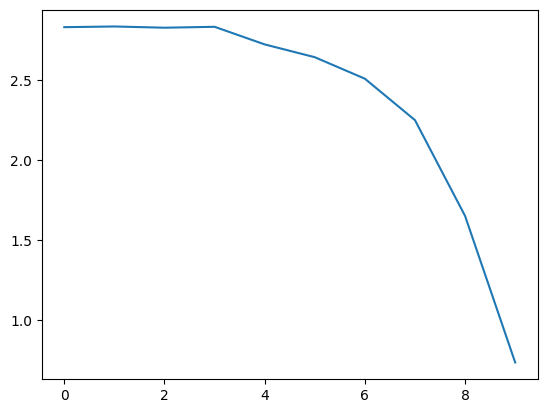

In [ ]:
plt.plot(CHSH_values)

In [ ]:
a_dag = qt.create(N).full()
I = qt.identity(N).full()

a_H = np.kron(a_dag, I)
a_V = np.kron(I, a_dag)

# Testing the case with only one MPS for both control and target
vacuum = create_vacuum_state(num_modes=2, N=N)
# control_operator = 1/np.sqrt(3) * a_H + np.sqrt(2/3) * a_V
pure_EPPS_operator = a_V

input = pure_EPPS_operator @ vacuum.to_dense()
print_quantum_state(N, sp.csr_array(input), num_states = 1, return_string = False)

depolarized = rx(np.pi, N, return_unitary=True) @ input
print_quantum_state(N, sp.csr_array(depolarized), num_states = 2, return_string = False)

# pure_EPPS_operator_MPO = mpo.from_dense(pure_EPPS_operator, dims = N, sites = (0,1), L=2, tags="ideal_state")    
# psi = tensor_network_apply_op_vec(pure_EPPS_operator_MPO, vacuum, compress=True, contract = True, cutoff = 1e-15)

# read_quantum_state(psi, N, num_states = 1)

# rotator_node_1 = generalized_mode_mixer(site1 = 0, site2 = 1, theta = np.pi/2, phi = 0, psi = 0, lamda = 0, total_sites = 2, N = N, tag = 'MM')

# idler_rotated_psi = tensor_network_apply_op_vec(rotator_node_1, psi, compress=True, contract = True, cutoff = 1e-15)
# read_quantum_state(idler_rotated_psi, N, num_states = 1)

# POVM_1_OPs = generate_sqrt_POVM_MPO(sites = (1,), outcome = 1, total_sites=2, efficiency=1, N=N, pnr = False)

# idler_rotated_psi = tensor_network_apply_op_vec(POVM_1_OPs[0], idler_rotated_psi, compress=True, contract = True, cutoff = 1e-15)
# read_quantum_state(idler_rotated_psi, N, num_states = 1)

# idler_rotated_psi.norm()**2

Corresponding Basis terms:
0H1V_A - 1 - [1.+0.j]
Corresponding Basis terms:
0H0V_B 1H0V_A - 2 - [0.-1.j]


Corresponding Basis terms:
0H1V_B 0H1V_A - 5 - [0.70710678+0.j]
1H0V_B 1H0V_A - 10 - [0.70710678+0.j]


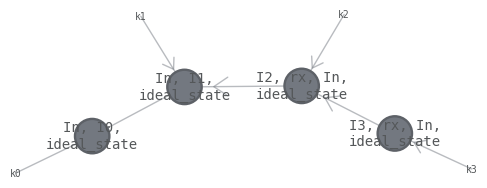

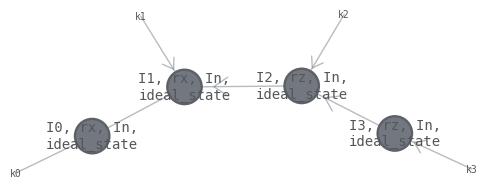

Corresponding Basis terms:
0H1V_B 1H0V_A - 6 - [-0.70710678-0.j]
1H0V_B 0H1V_A - 9 - [0.70710678+0.j]


checking all depolarizing ops
MatrixProductOperator([
    Tensor(shape=(2, 2, 1), inds=('k0', 'b0', '_9b19a9AAAii'), tags=oset(['I0', 'op']), left_inds=('k0', 'b0')),
    Tensor(shape=(1, 2, 2), inds=('_9b19a9AAAii', 'k1', 'b1'), tags=oset(['I1', 'op'])),
], tensors=2, indices=5, L=4, max_bond=1)
Corresponding Basis terms:
0H1V_B 0H1V_A - 5 - [0.5+0.j]
1H0V_B 1H0V_A - 10 - [0.5+0.j]
MatrixProductOperator([
    Tensor(shape=(2, 2, 4), inds=('k0', 'b0', '_9b19a9AAAij'), tags=oset(['I0', 'op']), left_inds=('k0', 'b0')),
    Tensor(shape=(4, 2, 2), inds=('_9b19a9AAAij', 'k1', 'b1'), tags=oset(['I1', 'op'])),
], tensors=2, indices=5, L=4, max_bond=4)
Corresponding Basis terms:
0H1V_B 1H0V_A - 6 - [0.-0.28867513j]
1H0V_B 0H1V_A - 9 - [0.-0.28867513j]
MatrixProductOperator([
    Tensor(shape=(2, 2, 4), inds=('k0', 'b0', '_9b19a9AAAik'), tags=oset(['I0', 'op']), left_inds=('k0', 'b0')),
    

In [ ]:
from trajectree.trajectory import quantum_channel

depolarization_probability = 0.5

quantum_channel_list = []
# depolarizing_kraus_ops = two_qubit_depolarizing_channel(depolarizing_probability = depolarization_probability, N = N)
# quantum_channel_list.append(quantum_channel(N = N, num_modes = 8, formalism = "kraus", kraus_ops_tuple = ((0,1,2,3), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.

depolarizing_kraus_ops = depolarizing_operators(depolarizing_probability = depolarization_probability, N = N)
quantum_channel_list.append(quantum_channel(N = N, num_modes = 4, formalism = "kraus", kraus_ops_tuple = ((0,1), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.
quantum_channel_list.append(quantum_channel(N = N, num_modes = 4, formalism = "kraus", kraus_ops_tuple = ((2,3), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.


rx_MPO = rx(np.pi, N, return_unitary = False, site1 = 2, site2 = 3, total_sites=4)
psi = create_perfect_bell_state(N=N)
read_quantum_state(psi, N, num_states = 2)
psi = tensor_network_apply_op_vec(rx_MPO, psi, compress=True, contract = True, cutoff = error_tolerance)
psi.draw()
# read_quantum_state(psi, N, num_states = 2)

psi = create_perfect_bell_state(N=N)
rx_MPO = rx(np.pi, N, return_unitary = False, site1 = 0, site2 = 1, total_sites=4)
psi = tensor_network_apply_op_vec(rx_MPO, psi, compress=True, contract = True, cutoff = error_tolerance)

rx_MPO = rz(np.pi, N, return_unitary = False, site1 = 2, site2 = 3, total_sites=4)
psi = tensor_network_apply_op_vec(rx_MPO, psi, compress=True, contract = True, cutoff = error_tolerance)

psi.draw()
read_quantum_state(psi, N, num_states = 2)

print("\n\nchecking all depolarizing ops")

for i in range(len(depolarizing_kraus_ops)):
    psi = create_perfect_bell_state(N=N)
    print(quantum_channel_list[0].get_MPOs()[i])
    psi = tensor_network_apply_op_vec(quantum_channel_list[0].get_MPOs()[i], psi, compress=True, contract = True, cutoff = error_tolerance)
    read_quantum_state(psi, N, num_states = 2)
for i in range(len(depolarizing_kraus_ops)):
    psi = create_perfect_bell_state(N=N)
    print(quantum_channel_list[1].get_MPOs()[i])
    psi = tensor_network_apply_op_vec(quantum_channel_list[1].get_MPOs()[i], psi, compress=True, contract = True, cutoff = error_tolerance)
    psi = tensor_network_apply_op_vec(quantum_channel_list[0].get_MPOs()[i], psi, compress=True, contract = True, cutoff = error_tolerance)
    read_quantum_state(psi, N, num_states = 2)
# perform_simulation(N, 50, quantum_channel_list)